## Trabalho final

O seguinte trabalho tem por objetivo desenvolver uma rede neural capaz de prever a altura de um rio baseado nos valores dos últimos 15 dias anteriores
Para isso utilizou-se Redes Neurais Recorrentes (LSTM) dado sua alta eficácia com séries temporais

## Importação das bibliotecas

In [56]:
import pandas as pd
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Análise exploratória dos dados

In [57]:
def read_archive(path_arquivo):
    lines = [] 
    with open(path_arquivo) as arquivo:
        for line in arquivo:
            lines.append(line.split())
    df = pd.DataFrame(lines, columns= ['DIA', 'MES', 'ANO', 'MEDICAO'])
    return df

def dados(dado):
    ano = dado['ANO']
    mes = dado['MES']
    dia = dado['DIA']
    medidas = {"DATA":[], "MEDICAO":[]}
    for med in range(len(dado['ANO'])):
        if float(dado['MEDICAO'][med]) > 0:
            d = int(dia[med])
            m = int(mes[med])
            medidas['DATA'].append(date(int(ano[med]), m, d))
            medidas['MEDICAO'].append(float(dado['MEDICAO'][med]))
    return medidas

In [58]:
df = read_archive("15700000.txt")

In [59]:
df = pd.DataFrame(dados(df))

In [60]:
def calcula_media_mensal(df):
    medias_mensais = {'data':[], 'media': []}
    for x in range(len(df)):
        ano = df.DATA[x].year
        mes = df.DATA[x].month
        
        somatorio = 0
        qtd_medicoes = 0
        
        for m in range(x, len(df)):
        
            if df.DATA[m].month != mes:
                break
            else:
                somatorio+=df.MEDICAO[m]
                qtd_medicoes+=1
        if date(int(ano), mes, 15) not in medias_mensais['data']:
            
            medias_mensais['data'].append(date(int(ano), mes, 15))
            medias_mensais['media'].append(somatorio/qtd_medicoes)
            
    return medias_mensais

In [61]:
import matplotlib.pyplot as plt

def plot(quem, x,y, titulo, x_description, y_description, color, xticks= False, yticks= False, size= (14,3), name = ''):

    colors = {'Blue': ('#00243c', '#00507D', '#0392BE', '#07ADC7', '#45C7C9', '#45C7C9', '#D6FFFD'), 
              'Green': ('#FFFFFF','#A3DFC3', '#6AB982', '#5E885B','#4A692D','#618700', '#4A692D')}
    if quem.upper() == 'Joao':
        cor = 'Blue'
    else:
        cor = 'Green'
    ax = plt.axes()
    plt.gcf().set_size_inches(size)

    ax.plot(x,y, color = colors[cor][color['line']])
    
    
    ax.set_title(str(titulo), fontdict=None, loc='center', pad=None)    
    ax.set_xlabel(x_description)
    ax.set_ylabel(y_description)
    #ax.set_axis_off()
    
    if name == '':
        fgura = 'figura'
    else:
        fgura = name
    
    plt.savefig(f'{fgura}.png', dpi= 200, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    return None


Os dados foram coletados da estação hidrológica da cidade de Humaitá - AM

Os dados correspondem á valores de cota (altura do rio) na estação hidrológica

Vale ressaltar que os valores se referem a bacia hidrográfica do Rio Madeira

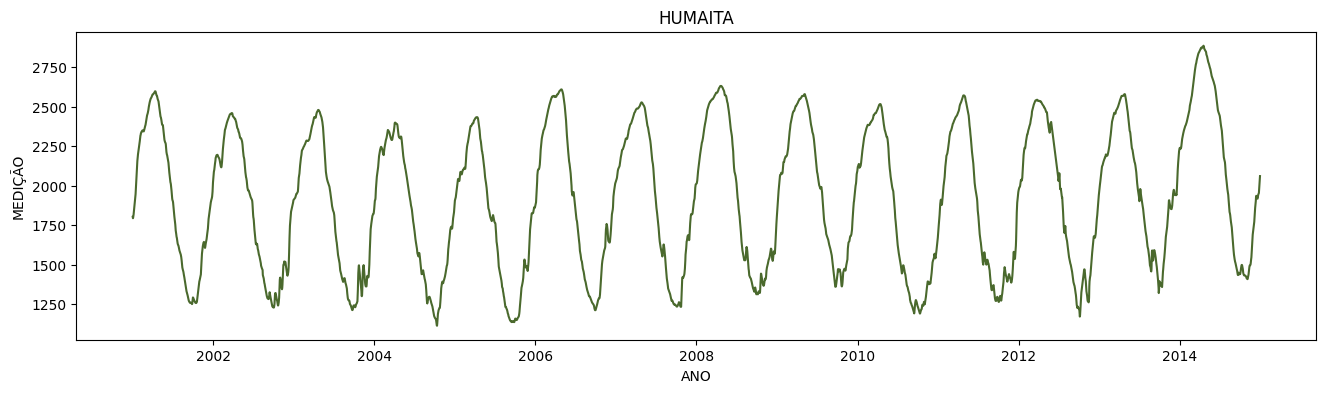

In [62]:
df.MEDICAO.max()
medias = pd.DataFrame(calcula_media_mensal(df))

plot('FERNANDO', df.DATA, df.MEDICAO, 'HUMAITA', 'ANO', 'MEDIÇÃO', {'background': 6, 'line': 4, 'y_ticks' : 3}, size= (16,4))

## Preparação dos dados

In [63]:
df

,DATA,MEDICAO
0,2001-01-01,1803.0
1,2001-01-02,1794.0
2,2001-01-03,1799.0
3,2001-01-04,1808.0
4,2001-01-05,1818.0
...,...,...
5108,2014-12-27,1982.0
5109,2014-12-28,1996.0
5110,2014-12-29,2017.0
5111,2014-12-30,2042.0


In [64]:
date_time = pd.to_datetime(df.pop('DATA'), format='%Y-%m-%d')

In [65]:
df

,MEDICAO
0,1803.0
1,1794.0
2,1799.0
3,1808.0
4,1818.0
...,...
5108,1982.0
5109,1996.0
5110,2017.0
5111,2042.0


In [66]:
df.values
df = df.astype('float32')

Normalização dos dados

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [68]:
df

array([[0.38895148],
       [0.38387817],
       [0.38669676],
       ...,
       [0.5095828 ],
       [0.52367526],
       [0.5343855 ]], dtype=float32)

Função para criar arrays de 16 dias (15 dias para atributos preditores e 1 dia para atributo alvo)

In [69]:
def datasetLSTM(dataset, quantidade):
    df = []
    param1 = 0
    param2 = 0
    for i in range(len(dataset)):
        lista=[]
        try:
            lista.append(dataset[i])
            for j in range (quantidade):
                lista.append(dataset[i+j+1])
                param1 = i
                param2 = j
            lista.append(dataset[param1+param2+15])
            param1=0
            param2=0            
            df.append(lista)
        except:
            print("erro")
    return df

In [70]:
df2 = datasetLSTM(df, 14)

erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro


Datset de 16 dias

In [71]:
dfTest = pd.DataFrame(df2)
dfTest = dfTest.astype("float")
dfTest.columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','30']
dfTest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,30
0,0.388951,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.636979
1,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.641488
2,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.646561
3,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.652198
4,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.551860,0.658963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,0.332018,0.339910,0.347802,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.489853
5081,0.339910,0.347802,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.463923,0.497745
5082,0.347802,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.463923,0.463360,0.509583
5083,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.463923,0.463360,0.461105,0.523675


Partição holdout 80,20
80% dados de treino
20% dados de teste

In [72]:
test_size = int(len(dfTest) * 0.2)
test = dfTest.iloc[-test_size::].copy()
train = dfTest.iloc[:-test_size:].copy()

In [73]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,30
0,0.388951,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.636979
1,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.641488
2,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.646561
3,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.652198
4,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.551860,0.658963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063,0.702367,0.704622,0.709132,0.711387,0.713641,0.715896,0.718151,0.721533,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.799323
4064,0.704622,0.709132,0.711387,0.713641,0.715896,0.718151,0.721533,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.801578
4065,0.709132,0.711387,0.713641,0.715896,0.718151,0.721533,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.803269
4066,0.711387,0.713641,0.715896,0.718151,0.721533,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.804397


In [74]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,30
4068,0.715896,0.718151,0.721533,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.804961
4069,0.718151,0.721533,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.804397
4070,0.721533,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.804397
4071,0.727170,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.805524
4072,0.733371,0.736753,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.806652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,0.332018,0.339910,0.347802,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.489853
5081,0.339910,0.347802,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.463923,0.497745
5082,0.347802,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.463923,0.463360,0.509583
5083,0.353439,0.357948,0.362458,0.370913,0.385006,0.396843,0.408681,0.420519,0.428410,0.435175,0.445321,0.458850,0.463923,0.463360,0.461105,0.523675


In [75]:
X_train = train.drop("30",axis=1).copy()

In [76]:
y_train = train[["30"]].copy()
y_train

,30
0,0.636979
1,0.641488
2,0.646561
3,0.652198
4,0.658963
...,...
4063,0.799323
4064,0.801578
4065,0.803269
4066,0.804397


Os modelos serão executados usando a biblioteca tensorflow e o framework keras, portanto os valores usados nas execuções não podem ser classes da biblioteca Pandas

Logo, faz-se necessário a transformação para arrays Numpy

In [77]:
scaled_X_train = X_train.to_numpy()

In [78]:
scaled_X_train

array([[0.38895148, 0.38387817, 0.38669676, ..., 0.45828635, 0.47012395,
        0.4859075 ],
       [0.38387817, 0.38669676, 0.39176995, ..., 0.47012395, 0.4859075 ,
        0.50338215],
       [0.38669676, 0.39176995, 0.397407  , ..., 0.4859075 , 0.50338215,
        0.51972944],
       ...,
       [0.7091319 , 0.71138662, 0.71364146, ..., 0.75479144, 0.7643742 ,
        0.76888388],
       [0.71138662, 0.71364146, 0.71589619, ..., 0.7643742 , 0.76888388,
        0.77113861],
       [0.71364146, 0.71589619, 0.71815103, ..., 0.76888388, 0.77113861,
        0.77339345]])

In [79]:
scaled_y_train = y_train.to_numpy()
scaled_y_train

array([[0.63697857],
       [0.64148813],
       [0.64656144],
       ...,
       [0.80326945],
       [0.80439681],
       [0.80496055]])

In [80]:
scaled_y_train = scaled_y_train.reshape(-1)
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

In [81]:
scaled_y_train

array([0.        , 0.63697857, 0.64148813, ..., 0.80157834, 0.80326945,
       0.80439681])

Criação dos valores de entrada

In [82]:
n_input = 15
n_features= X_train.shape[1]
b_size = 32
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

In [83]:
print(generator[0][0].shape)

(32, 15, 15)


## Execução

Geração das arquiteturas

Para este trabalho optou-se por uma rede LSTM com 150 unidades (hidden states) e 1 camada oculta

In [84]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               99600     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 99,751
Trainable params: 99,751
Non-trainable params: 0
_________________________________________________________________


Execução do treino

In [85]:
model.fit_generator(generator,epochs=50)

Epoch 1/50


C:\Users\hacke\AppData\Local\Temp\ipykernel_13348\3701096696.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=50)


127/127 [==============================] - 2s 8ms/step - loss: 0.0393
Epoch 2/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0110
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0098
Epoch 4/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0096
Epoch 5/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0067
Epoch 6/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0074
Epoch 7/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0058
Epoch 8/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0054
Epoch 9/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0044
Epoch 10/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 11/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 12/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 13/50
127/127 [===============

Gráfico de loss durante o treino

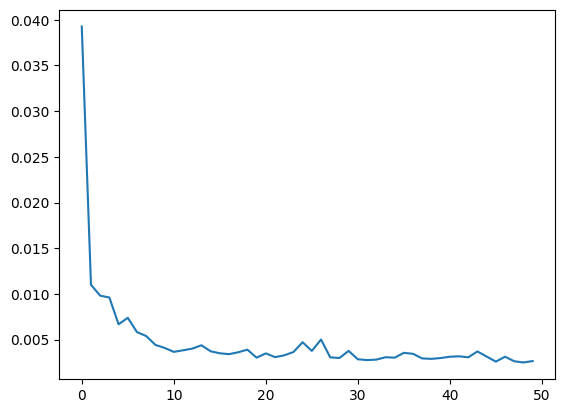

In [86]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

Teste

In [87]:
y_test = test[["30"]]
scaled_y_test = y_test.to_numpy()
scaled_y_test

array([[0.80496055],
       [0.80439681],
       [0.80439681],
       ...,
       [0.50958282],
       [0.52367526],
       [0.5343855 ]])

In [88]:
X_test = test.drop("30",axis=1).copy()
scaled_X_test  = X_test.to_numpy()
test_generator = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_input, batch_size=b_size)

Predição do modelo

In [89]:
y_pred_scaled = model.predict(test_generator)

32/32 [==============================] - 0s 4ms/step


In [90]:
y_pred_scaled

array([[0.8173605 ],
       [0.81702197],
       [0.8164009 ],
       ...,
       [0.5402577 ],
       [0.54941803],
       [0.55628455]], dtype=float32)

In [91]:
results = pd.DataFrame({'Dados Reais':test["30"].values[n_input:],'Dados Previstos':y_pred_scaled.ravel()})

Gráfico de valores 

reais x previsão

<Axes: title={'center': 'Gráfico de comparação dados reais x previstos'}>

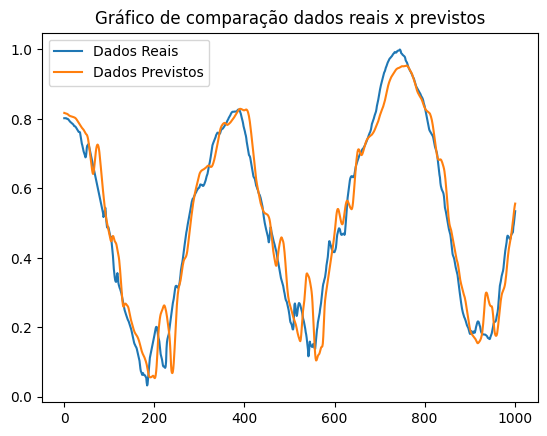

In [92]:
results.plot(title="Gráfico de comparação dados reais x previstos")

## Métricas de desempenho

In [93]:
import tensorflow as tf

Mean Squared Error

In [94]:
mse = tf.keras.losses.MeanSquaredError()

In [95]:
print("Mean Squared Error: " + str(mse(test["30"].values[n_input:], y_pred_scaled).numpy()))

Mean Squared Error: 0.13618463


Root Mean Squared Error

In [96]:
rmse = tf.keras.metrics.RootMeanSquaredError()

In [97]:
print("Root Mean Squared Error: " + str(rmse(test["30"].values[n_input:], y_pred_scaled).numpy()))

Root Mean Squared Error: 0.063384786


Mean Absolute Error

In [98]:
mae = tf.keras.losses.MeanAbsoluteError()

In [99]:
print("Mean Absolute Error: " + str(mae(test["30"].values[n_input:], y_pred_scaled).numpy()))

Mean Absolute Error: 0.3008951


R Squared

In [100]:
from sklearn.metrics import r2_score

In [101]:
r2 = r2_score(test["30"].values[n_input:], y_pred_scaled)

In [102]:
print("R-Squared metric: "+ str(r2))

R-Squared metric: 0.9421313711421768
